# Project Catch Joe

## Index

1 Introduction  
&emsp;&emsp; 1.1 Import modules  
&emsp;&emsp; 1.2 Load dataset  
    
 
2 Data Exploration  
&emsp;&emsp; 2.1 Location  
&emsp;&emsp; 2.2 Gender  
&emsp;&emsp; 2.3 Language  
&emsp;&emsp; 2.4 Operating System  
&emsp;&emsp; 2.5 Browser  
&emsp;&emsp; 2.6 Time of the day  
&emsp;&emsp; 2.7 Day of the week  
&emsp;&emsp; 2.8 Day of the month  
&emsp;&emsp; 2.9 Month of the year  
&emsp;&emsp; 2.10 Duration  
&emsp;&emsp; 2.11 Sites  
    
    
3 Predictive Model  
&emsp;&emsp; 3.1 Naive Guess Analysis  
&emsp;&emsp; 3.2 Decision Tree  
&emsp;&emsp; 3.3 Random Forest
  
  
4 Save  
&emsp;&emsp; 4.1 Storage model parameters  
&emsp;&emsp; 4.2 Run on Verify dataset  
&emsp;&emsp; 4.3 Export this Notebook to Python code

<p>&nbsp;</p>

# &#x2615;  1 Introduction

## 1.1 Context

The present Jupyter Notebook explains the process of creating a predictive model to identify an user access as **Joe** or **not-Joe** using this [dataset](https://drive.google.com/file/d/1nATkzOZUe6w5IWcFNE3AakzBl-6P-5Hw/view?usp=sharing).

The dataset contains data about user sessions that have been recorded over a period of time. The dataset consists of two parts: the training dataset where user ID’s are labeled, and the verification set without labels.

Each session is represented by a JSON object with the following fields:
- `user_id` is the unique identifier of the user.
- `browser`, `os`, `locale` contain info about the software on the user’s machine.
- `gender`, `location` give analytics data about the user.
- `date` and `time` is the moment when the session started (in GMT).
- `sites` is a list of up to 15 sites visited during the session. For each site, the url and the length of visit in seconds are given.

## 1.1 Import modules

In [1]:
import catch_joe
from catch_joe import \
        extract_weekday, extract_duration, extract_hour_local, extract_lengths, \
        extract_sites_ratio, extract_sites_joe, extract_site_history,\
        extract_hosts, extract_hosts_joe, intersection_ratio, \
        categorize, encode_features, encode_joe, transform_features, print_scores

In [2]:
import os
from dtreeviz.trees import dtreeviz
os.environ["PATH"] += os.pathsep + 'C:/Users/Diogo/anaconda3/Library/bin/graphviz'

from collections import Counter
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import SVG

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## 1.2 Load dataset

The dataframe below is what all the information available in the JSON file.

It contains all the information in a typical JSON to be classified, except that this one has an extra column with the label `user_id` for training purpose. We will use it to create another column with booleans to explicit if it is related to `user_id = 0 `, nicknamed as **Joe**.

In [4]:
file = './data/dataset.json'

df = pd.read_json(file)

# create target label as a separate column
user_id_joe = 0
df['joe'] = df['user_id'] == user_id_joe

print(df.shape)
df.head()

(80000, 10)


,browser,os,locale,user_id,gender,location,sites,time,date,joe
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",09:03:00,2017-01-08,False
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",13:57:00,2016-10-05,False
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",02:06:00,2017-03-28,False
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",21:49:00,2017-06-25,False
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",00:05:00,2016-02-10,False


Before everything, let's split the data now in order to guarantee that there is no _Data Leakage_ in the following phase during our data exploration and analysis. Mind that this is a time-series data, so we will split it in the chronological order (instead of random sampling). The later dataset will be used to test and score our predictive model.

In [5]:
# split dataset into train and test
# in chronological order (not random)

test_ratio = 0.1
df_later = df.sort_values(by='date').tail(int(test_ratio * df.shape[0]))

df = df.drop(df_later.index) # train dataset

df.shape

(72000, 10)

<p>&nbsp;</p>

# &#x1f4c8; 2 Data Exploration

Let's go through a series of plots throughout the dataset in order to extract insights and patterns that will be used by our predictive model later on.

## 2.1 Gender

The first feature to be explored is `gender`. Let's explore the hypothesis that Joe never changed their gender.

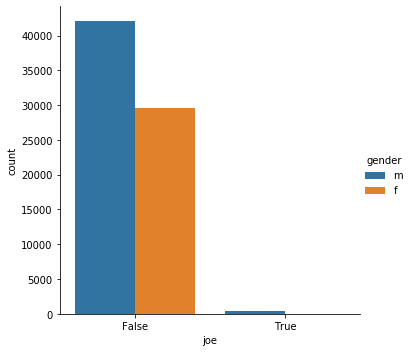

In [189]:
_ = sns.catplot(x='joe', hue='gender', kind='count', data=df)

It seems that Joe is consistently identified as a male, since there is no log on his name as female. This insight is useful to discard around 40% of the dataset.

## 2.2 Location

Now, let's now explore `location`. Unless Joe lives in a cruising ship, he probably has little change of location around the globe.

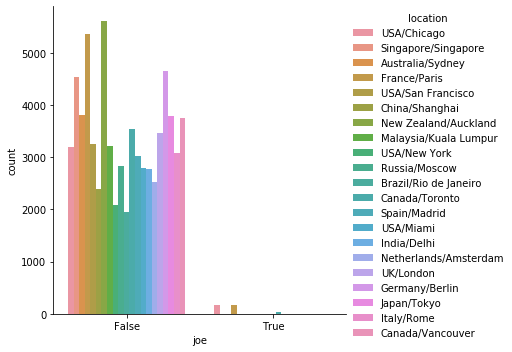

In [190]:
_ = sns.catplot(x='joe', hue='location', kind='count', data=df)

In [8]:
Counter(df[df['joe']]['location'])

Counter({'France/Paris': 164, 'USA/Chicago': 160, 'Canada/Toronto': 35})

Joe accessed from Paris, Chicago and Toronto only. This is helpful to discard the other 18 locations.

## 2.3 Language

Let's now explore `locale`. It is rare to find an active polyglot so let's explore this hypothesis.

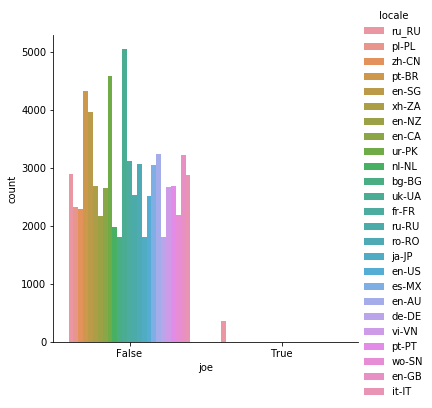

In [191]:
_ = sns.catplot(x='joe', hue='locale', kind='count', data=df)

In [10]:
Counter(df[df['joe']]['locale'])

Counter({'ru_RU': 359})

Despite the fact that Joe has many access from France, USA and Canada, his sessions are always in Russian language. Again, this eliminates all the other languages.

## 2.4 Operating System

If Joe is not a geek than he is probably using only one or two different `os`.

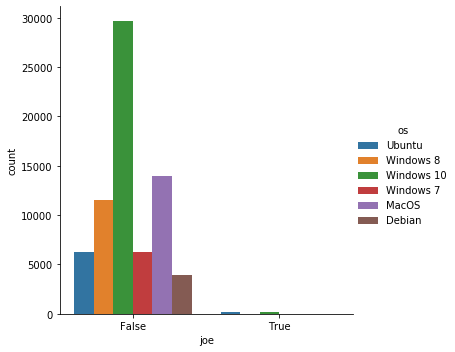

In [192]:
_ = sns.catplot(x='joe', hue='os', kind='count', data=df)

Indeed, Joe uses only Ubuntu and Windows 10. This rules out MacOS, Debian and the rest of the Microsoft's OS.

## 2.5 Browser

For the same reason explained before for the OS, Joe is probably using only a couple of `browsers`.

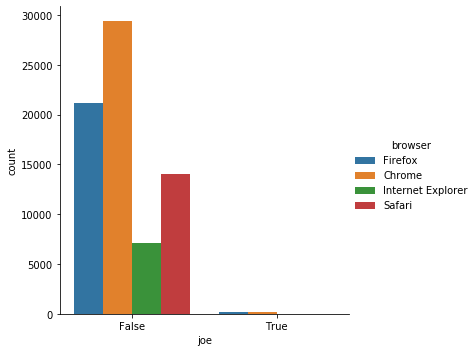

In [193]:
_ = sns.catplot(x='joe', hue='browser', kind='count', data=df)

Joe always uses Firefox and Chrome, ruling out Internet Explorer and Safari.

## 2.6 Time of the day

Let's now verify the hypothesis that Joe accesses internet only in some specific hours of the day. Mind that there is a conversion from GMT to local timezone.

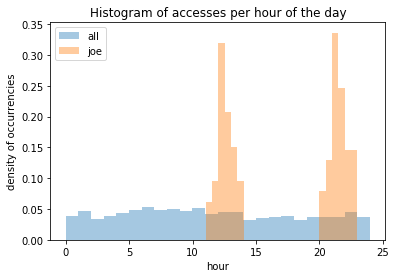

In [13]:
df['hour'] = extract_hour_local(df)

# plot
sns.distplot(df['hour'],            norm_hist=True, kde=False, rug=False, bins=24)
sns.distplot(df[df['joe']]['hour'], norm_hist=True, kde=False, rug=False, bins=24)
plt.legend(['all', 'joe'])
plt.title('Histogram of accesses per hour of the day')
_ = plt.ylabel('density of occurrencies')

Joe accesses internet only during lunch or dinner. Therefore, hour of access is yet another relevant information to be used by our classifier.

## 2.7 Day of the week

Following the rationale from the previous subsection, let's verify the hypothesis that Joe accesses internet only in some specific days of the week.

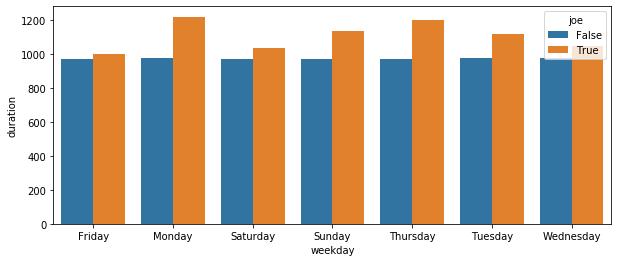

In [275]:
df['weekday'] = extract_weekday(df)

plt.figure(figsize=(10,4))
_ = sns.barplot(data=df[['weekday', 'duration', 'joe']].groupby(['weekday', 'joe']).mean().reset_index(),
            x='weekday', y='duration', hue='joe')

In [15]:
Counter(df[df['joe']]['weekday'])

Counter({'Saturday': 53,
         'Tuesday': 52,
         'Sunday': 53,
         'Friday': 54,
         'Wednesday': 49,
         'Monday': 46,
         'Thursday': 52})

There are some usedful patterns along the days of the week! For instance, on the one hand Joe acesses internet on Mondays less often (`46` from the counter) but on the other hand when he does so he spend the most time on average. As a consequence, let's drop this feature.

## 2.8 Day of the month

Let's verify if Joe has different frequency of access along the days of the month.

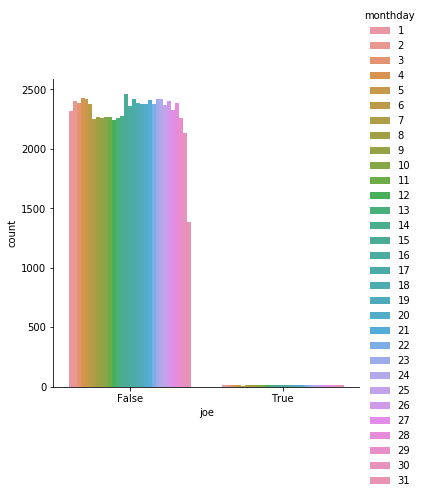

In [195]:
df['monthday'] = [date.day for date in df['date']]

_ = sns.catplot(x='joe', hue='monthday', kind='count', data=df)

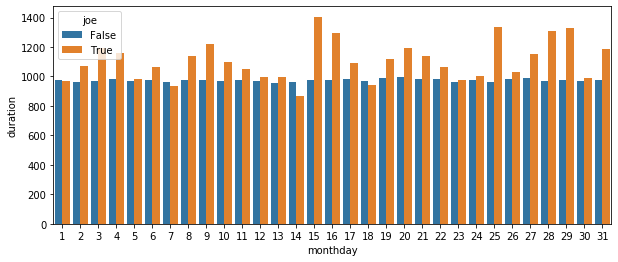

In [274]:
plt.figure(figsize=(10,4))
_ = sns.barplot(data=df[['monthday', 'duration', 'joe']].groupby(['monthday', 'joe']).mean().reset_index(),
            x='monthday', y='duration', hue='joe')

It seems that Joe browses for longer durations along the days of the month, following a repeating pattern with a period of roughly 1 week. More importantly, this differs from the population's pattern so it is useful to find Joe as well.

## 2.9 Month of the year

Now, let's check the data regarding the months of the year.

In [279]:
df.date.min(), df.date.max()

(Timestamp('2016-01-14 00:00:00'), Timestamp('2017-07-07 00:00:00'))

Unfortuately, the training dataset contains around 1.5 years of timespan. It means that 6 (out of the 12 months) have twice more probability to appear in the data. This could be lead to overfitting, so let's not include this feature.

## 2.10 Duration

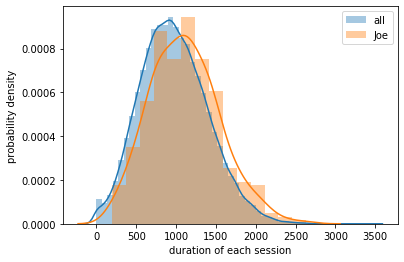

In [197]:
df['duration'] = extract_duration(df)

sns.distplot(df           ['duration'])
sns.distplot(df[df['joe']]['duration'])
plt.xlabel('duration of each session')
plt.ylabel('probability density')
_ = plt.legend(['all', 'Joe'])

Joe's duration of access is only slightly off the statistical boundaries of the whole population. Nonetheless, let's keep this feature since it might be useful when correlated with other features (ie: he might access some specific sites for longer).

# 2.11 Sites

The list of sites accessed per session and its respective lengths do sound like a pretty relevant information. We all have our own favorite sites that we access most often by far from the others. If such data is the user's "digital footprint" then their "digital gait" could be used to identify them, hopefully including Joe.

In [19]:
sites_joe = extract_sites_joe(df)
print(len(sites_joe), 'sites accessed by Joe.')

1079 sites accessed by Joe.


In [22]:
sites_joe_list = list(sites_joe)
df_sites_joe_length = extract_lengths(df[df['joe']], sites_joe_list)
df_sites_joe_length = df_sites_joe_length.mean().sort_values(ascending=False)

print("Most and least sites accessed by Joe:")
print('\nADDRESS \t AVERAGE LENGTH OF SESSION')
df_sites_joe_length

Most and least sites accessed by Joe:

ADDRESS 	 AVERAGE LENGTH OF SESSION


lenta.ru             126.693593
slack.com            120.256267
mail.google.com      119.462396
toptal.com           119.144847
vk.com               113.791086
                        ...    
univ-paris12.fr        0.111421
ifsttar.fr             0.111421
calendrier-365.fr      0.111421
smartsheet.com         0.111421
airbnb.fr              0.111421
Length: 1079, dtype: float64

In [23]:
df_sites_all_length = extract_lengths(df, sites_joe_list)

print("Most and least sites accessed by the whole population:")
print('\nADDRESS \t AVERAGE LENGTH OF SESSION')
df_sites_all_length.mean().sort_values(ascending=False)

Most and least sites accessed by the whole population:

ADDRESS 	 AVERAGE LENGTH OF SESSION


youtube.com             39.097875
toptal.com              31.048542
slack.com               30.621389
vk.com                  26.454833
lenta.ru                25.212111
                          ...    
cnrm-game.fr             0.016111
as.com                   0.015694
courtine.org             0.015375
adgrx.com                0.014389
foret-broceliande.fr     0.014375
Length: 1079, dtype: float64

The sites most accessed by Joe have links and lengths different than the population. So, this information is useful as well.

However, let's extract only the top ones in order to avoid overfitting and heavy computational cost. The quantity of top sites in the list (`500`) was defined by rerunning this notebook many times with decreasing numbers from the maximum until the performance of the best classifier started to drop.

In [24]:
top_sites = 500
joe_all_sites = list(df_sites_joe_length[:top_sites].index)
joe_top_sites = joe_all_sites[:top_sites]

In [26]:
df_sites_joe_length.head()

lenta.ru           126.693593
slack.com          120.256267
mail.google.com    119.462396
toptal.com         119.144847
vk.com             113.791086
dtype: float64

We don't need to throw away the information related to the rest of the websites that were never accessed by Joe. Let's create another feature with as a flag if any of the sites in a session was ever accessed by Joe.

We will not plot this data because obviously it would bring no useful insight, since all the plots from Joe's accesses will be True as opposite to a part of the training dataset

In [57]:
df['site_history'] = extract_site_history(df, sites_joe)

<p>&nbsp;</p>

# &#128187; 3 Predictive Model

## 3.1 Naive Guess Analysis

The previously mentioned features are good enough to safely tell whenever is not Joe.

What if they are good enough to be queried independentely as filters to discard parts of the data until we have only Joe left?

In orde to find this out, let's check how many logs match exactly the Joe's history from the categorical features. 

In [60]:
# define list of features to be used by the classifier

features_categorical = ['gender', 'os', 'browser', 'location', 'locale', 'hour', 'weekday', 'site_history']

features = features_categorical + ['duration'] + joe_top_sites

In [61]:
df_like_joe = df.copy()

filter_data = {feat: set(df[df['joe']][feat]) for feat in features_categorical}

for feature, valid_entries in filter_data.items():
    df_like_joe = df_like_joe[df_like_joe[feature].isin(valid_entries)]

    
# extract set of multiple website entries from Joe's logs
sites_joe = extract_sites_joe(df)#{site.get('site') for sites in df_like_joe['sites'] for site in sites}
df_like_joe = df_like_joe[list(map(lambda x:
                any(site.get('site') in sites_joe for site in x), df_like_joe['sites']))]
    
    
print('Original dataset contains', df.shape[0], 'logs.')
print('Like-Joe dataset contains', df_like_joe.shape[0], 'logs',
     "({0:.0%}).".format(df_like_joe.shape[0] / df.shape[0]))

Original dataset contains 72000 logs.
Like-Joe dataset contains 897 logs (1%).


Filtering the sessions that do not match Joe's history is enough to discard a large piece of the dataset.

But how many of the left logs are our Joe indeed?

In [62]:
count = Counter(df_like_joe['joe'])
print(count)

is_joe = np.asarray([count[False], count[True]])
is_joe = list(is_joe / is_joe.sum())

print('False and True sessions ratio from Joe:', ', '.join('{0:.1%}'.format(i) for i in is_joe))

Counter({False: 538, True: 359})
False and True sessions ratio from Joe: 60.0%, 40.0%


In [63]:
user_id_like_joe = set(df_like_joe['user_id'])
print(len(user_id_like_joe), 'total of user_id with same logs than Joe:', *user_id_like_joe)

5 total of user_id with same logs than Joe: 0 192 15 181 56


Despite the fact that the filter above efficiently removed most of the dataset, there are yet some sessions from a few people with enough occurencies to be a majority over Joe. This is yet something to be tackled, since we don't want these people being taken as Joe.

Before creating our predictive model in the next subsection, let's calculate the naive guess performance. We know that the majority of the data is not from Joe so the naive guess classifier always assume that the result is 1 (not Joe).

In [64]:
df_train = df.copy()

df_train, le = categorize(df_train, features_categorical)

y_train = encode_joe(df_train['user_id'] == user_id_joe)
df_train = transform_features(df_train, features, features_categorical, joe_top_sites, sites_joe, hosts_joe, le)

for host in hosts_joe:
    df_train[host] = [sum(map(lambda x: x.get('length') * (x.get('site').split('.')[-1] == host), sites)) for sites in df['sites']]

X_train = df_train[features].values

In [65]:
y_pred = [1] * len(y_train)

print('Performance of naive guess on train dataset:')
print_scores(y_pred, y_train)

Performance of naive guess on train dataset:
99.5014% is the accuracy of the classifier.
0.0000% is the F1-score of the classifier.
0.00% of the Joe's accesses are detected.
0.00% of the detections are truly from Joe.


C:\Users\Diogo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As expected, the accuracy score is quite high because the data is largely imbalanced with not-Joe sessions.

Moreover, precision and recall scores are obviously nulls because the naive guess blindly guesses as not Joe.

For these reasons, **our chosen metric will be the F1-score**, resulting in:
- F1-score = 0% is our reference as benchmarked by our naive guess; and
- Both precision and recall scores are going to be equally considered.

## 3.2 Decision Tree

Maybe, the correlation of every restriction is better enough to find Joe out of the other few people above. For instance, Joe might be the only one who uses Firefox (`browser`) on Windows 10 (`os`).

In order to check if this hypothesis, let's plot some correlations.

Correlation is an usuful plot to show the influence of one information on the other.

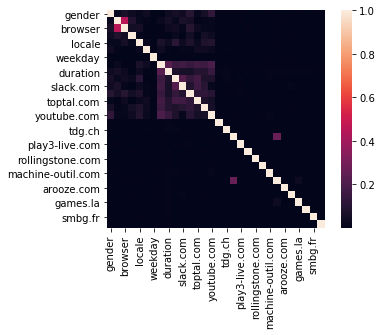

In [178]:
corr_all = abs(df_train.iloc[:, :30].corr())
_ = sns.heatmap(corr_all, square=True)

Above is the correlation plot for the whole population (with a few dozens of features onlyfor pratical reasons). It reveals that usually there is no remarkable correlation between features to the point that we could drop some as redundant. The only average correlations are os/browser, duration/some sites and 1 pair on sites.

Let's compare it with the correlation from Joe's sessions only.

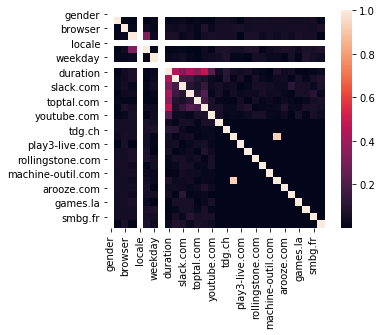

In [179]:
corr_joe = abs(df_train[np.array(y_train)==user_id_joe].iloc[:, :30].corr())
_ = sns.heatmap(corr_joe, square=True)

The Joe's correlation plot above reveals some visual differences from the population plot. These differences are peculiarities in Joe's behavior that differs from the population. This means that Joe has a particular pattern combining these features that are surely be useful for our classifier (ie: he may navigate for longer periods by the end of the month due to some private monthly dealines).
> **_NOTE:_**  The features in blank mean that the correlation does not make sense due to lack of variance (ie: `user_id`, `joe` and `site_history` are constants)

After realizing the importance of combining multiple features in order to find useful patterns, let's create a simple Decision Tree, train it on the single-entries categorical features and check it's performance to detect Joe.

In [186]:
# train model
n_features_categorical = len(features_categorical)
model = DecisionTreeClassifier(max_depth=3).fit(X_train[:, :n_features_categorical], y_train)

print('Performance on train dataset:')
y_pred = model.predict(X_train[:, :n_features_categorical])
print_scores(y_pred, y_train)

Performance on train dataset:
99.5500% is the accuracy of the classifier.
17.7665% is the F1-score of the classifier.
100.00% of the Joe's accesses are detected.
9.75% of the detections are truly from Joe.


The Decision Tree presents a slight increase of performance when compared to the naive guess. However, it is far from excellent since there are too wrong detections. Therefore, let's try other more sophisticated models aiming for a improvement in the performance (higher F1-score).

Before we move on to improve the performance, here is a question. How exactly does this Decision Tree above work in order to classify?

In order to help us answer this question, let's plot the nodes of the Decision Tree as a graph plot below.

In [332]:
viz = dtreeviz(model, X_train[:, :n_features_categorical], np.asarray(y_train),
                class_names=['Joe', 'not Joe'],
                feature_names=features_categorical,
        )
viz_file = 'decision_tree.svg'
viz.save(viz_file) # saves svg in local folder
# SVG(filename=viz_file) # plots svg in Jupyter Notebook
# Image(filename='decision_tree.jpg') # or like this

after converting the SVG to JPG, we get this

![](decision_tree.jpg)

In [69]:
le['locale'].inverse_transform([18])

array(['ru_RU'], dtype=object)

The graph above shows that the Decision Tree queries the features in the following order:
1. If the language (`locale`) is less than 17.5 then is not Joe with 100% of certainty; else ...
1. If the language (`locale`) is more than 18.5 then is is not Joe with 100% of certainty; else ...
1. If the (encoded) location of access is less than 3.5 than it is Joe with 100% of certainty; else ...
1. We run out of questions so it guesses it is not Joe with roughly 10% of error.

Mind that `locale = 18` is the Russian language as coded by the `LabelEncoder`. Therefore, the first 2 questions above are mainly telling us that if the language of access is not Russian than it is not 
Joe for sure.

## 3.3 Random Forest

Finally, now we create our final predictive model.

Let's start by preparing the test dataset following the same feature extraction pipeline as we did for the training dataset.

In [70]:
# prepare test dataset
df_test = df_later.copy()
y_test = encode_joe(df_test['user_id'] == user_id_joe)
df_test = transform_features(df_test, features, features_categorical, joe_top_sites, sites_joe, hosts_joe, le)

for host in hosts_joe:
    df_test[host] = [sum(map(lambda x: x.get('length') * (x.get('site').split('.')[-1] == host), sites)) for sites in df_later['sites']]

X_test = df_test[features].values

Now, let us instantiate and try some more sophisticted models candidates in order to select the one with best performance.

In [71]:
score_function = lambda x, y: f1_score(x, y, pos_label=user_id_joe)

models = [
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    BaggingClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    
    # these below were not included because
    # they take a long time and they
    # ended up not being selected anyway
    
#     GradientBoostingClassifier(),
#     KNeighborsClassifier(n_neighbors=200),    
#     QuadraticDiscriminantAnalysis(),
#     GaussianProcessClassifier(),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     SVC(),    
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     MLPClassifier(),
]

print('F1 test\t F1 train\t Model')

score_best = -np.Inf
best_model = None
for i_model, model in enumerate(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = score_function(y_test, y_pred)
        
    print('{0:.3%}\t'.format(score),
          '{0:.3%}\t'.format(score_function(y_train, model.predict(X_train))),
          type(model).__name__)
    
    if score > score_best:
        score_best = score
        best_model = model
    


print('\nBest model:', type(best_model).__name__)

print('\nPerformance on train dataset:')
y_pred = best_model.predict(X_train)
print_scores(y_train, y_pred)

print('\nPerformance on test dataset:')
y_pred = best_model.predict(X_test)
print_scores(y_test, y_pred)

F1 test	 F1 train	 Model
60.345%	 100.000%	 DecisionTreeClassifier
67.213%	 45.490%	 AdaBoostClassifier
58.120%	 97.734%	 BaggingClassifier
84.507%	 99.861%	 RandomForestClassifier
4.878%	 55.616%	 GaussianNB

Best model: RandomForestClassifier

Performance on train dataset:
99.9986% is the accuracy of the classifier.
99.8605% is the F1-score of the classifier.
99.72% of the Joe's accesses are detected.
100.00% of the detections are truly from Joe.

Performance on test dataset:
99.8625% is the accuracy of the classifier.
84.5070% is the F1-score of the classifier.
73.17% of the Joe's accesses are detected.
100.00% of the detections are truly from Joe.


The best classifier performance trained above is much better than the previous Decision Tree. On the one hand, when it predicts its Joe's sessions then it is rarely wrong. On the other hand, it has an average performance when it comes to false negatives, which means that sometimes it does not detect Joe's sessions.

The class of the final classifier is the Random Forest, an ensemble learning method that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) of the individual trees. It is less prone to overfitting while often presenting a better accuracy.

Let's take a look at a sample of wrong prediction from the test dataset.

In [73]:
l = (np.array(y_pred) != np.array(y_test))
i_wrong = (i for i,v in enumerate(l) if v)

In [74]:
i = next(i_wrong)
print('index:', i, ', y_pred:',  y_pred[i], ', y_test:', y_test[i])
df_later.iloc[i]

index: 70 , y_pred: 1 , y_test: 0


browser                                               Firefox
os                                                 Windows 10
locale                                                  ru_RU
user_id                                                     0
gender                                                      m
location                                       Canada/Toronto
sites       [{'site': 'mail.google.com', 'length': 93}, {'...
time                                                 02:04:00
date                                      2017-07-07 00:00:00
joe                                                      True
Name: 40691, dtype: object

All the categorical features seems like it's Joe. Asa  consequence, let's check the websites of this session.

In [75]:
df_later['sites'].iloc[i]

[{'site': 'mail.google.com', 'length': 93},
 {'site': 'vk.com', 'length': 87},
 {'site': 'toptal.com', 'length': 258},
 {'site': 'lenta.ru', 'length': 242},
 {'site': 'slack.com', 'length': 92},
 {'site': 'zara-static.cn', 'length': 47}]

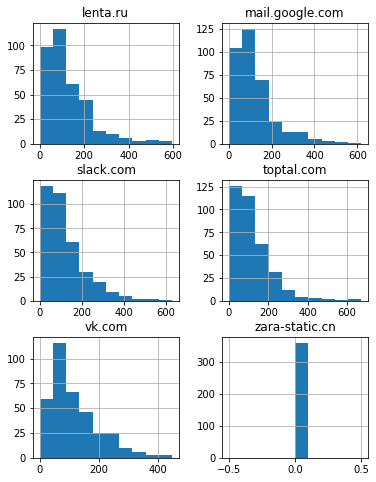

In [122]:
sites_this = list({site.get('site') for site in df_later['sites'].iloc[i]})
df_sites_joe_length_profile = extract_lengths(df[df['joe']], sites_this)
_ = df_sites_joe_length_profile.hist(figsize=(6, 8))
plt.gcf().patch.set_facecolor('white')

The plot above shows that the site `zara-static.cn` was not in Joe's history so the classifier mistakenly decided to not throw a positive detection. 

This shows that it is utterly important to retrain the predictive model whenever Joe changes his session pattern. Otherwise the performance will dive. For instance, if Joe starts a new session with another language other than Russian, this will cause the classifier to miss him since it is an unprecedented behavior that was obviously not considered during the training above. This is a common limitation across all predictive models, since all future inferences are assumed to be a good extrapolation of past learned patterns.

One could argue that we should then drop the sites from the list of features. However, this would bring the F1-score down to really low values since we would also lose the information regarding the Joe's behavior.

To make this point clearer, the plot below shows which features are the most relevant for the classifier.

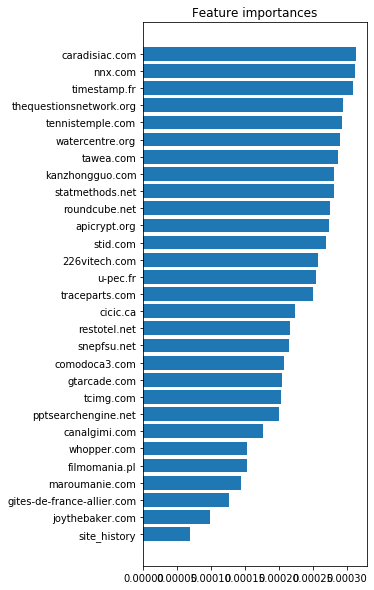

In [80]:
forest = best_model
plot_limit = 29

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[:plot_limit]

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(4, 10))
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [df_train.columns[i] for i in indices])
plt.show()

The list above shows that the length of session in each site is among the most important features. The other categorical features explored earlier are important for ruling out the majority of the dataset (the sessions that are obviously not Joe, ie: English language) and increase accuracy, but they are not very helpful to increase te F1-score (reliably detecting Joe).

Further optimization of Random Forest hyper-parameters using GridSearchCV was executed as shown below. However, it did not improve the F1-score. This means that the `best_model` above is the chosen one as the definitive.

In [146]:
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import GridSearchCV


# parameters = {
#     'n_estimators': [20, 40, 100, 200, 400, 1000],
#     'max_features': ['sqrt', 'log2'],
#     'criterion': ['gini', 'entropy'],
# }


# base_model = RandomForestClassifier()
# final_model = GridSearchCV(base_model, parameters, scoring=make_scorer(score_function),
#                            verbose=2, n_jobs=-1)
# final_model.fit(X_train, y_train)

# print('\nFinal model:', type(final_model).__name__)

# print('\nPerformance on train dataset:')
# y_pred = final_model.predict(X_train)
# print_scores(y_train, y_pred)

# print('\nPerformance on test dataset:')
# y_pred = final_model.predict(X_test)
# print_scores(y_test, y_pred)

<p>&nbsp;</p>

# &#x1f4be; 4 Save

## 4.1 Export the model parameters

It is time to store the model parameters necesary to run a standalone script defined in the `catch_joe` module.

In [207]:
catch_joe_model_parameters = {
    'model': best_model,
    'encoder': le,
    'joe_all_sites': sites_joe_list,
    'joe_top_sites': joe_top_sites,
    'joe_all_hosts': None,
    'features': features,
    'features_categorical': features_categorical,
}

with open('./model/catch_joe.pickle', 'wb') as f:
    pickle.dump(catch_joe_model_parameters, f)

## 4.2 Run on Verify dataset

Let's use the latest model saved above to run a standalone script.

In [208]:
!python catch_joe.py -j ./data/verify.json

In [221]:
with open('catch_joe_output.txt', 'r') as file:
    y_pred = file.read().splitlines()
    
    
y_pred = [int(y) for y in y_pred]
    
# alternatively, let's run it from the Jupyter Notebook
# so we get y_pred to print some results below
# y_pred = catch_joe.main(file_json = './data/verify.json')

count = Counter(y_pred)
print(count)
percentage = count[0] / (count[1] + count[0])
print('{0:.2%} of the predictions are detected as Joe\'s accesses.'.format(percentage))

Counter({1: 21170, 0: 1530})
6.74% of the predictions are detected as Joe's accesses.


We do not have the correct answers (`user_id`) in the `verify.json` file to assess the classifier's performance. However, just for the sake of curiosity, we can observe from the results above that our predictive model predicts Joe's sessions as the minority of the times. Such figure is expected for a real dataset that is expected to contain hundreds of users.

There is a difference in Joe's presence in the verify dataset compared to both the train and test. This might be an indication that the classifier is making some of mistakes because of an unexpected change of Joe's behavior (problem explained in the subsection). If that is the case then it would demand a further training with the new data to fix this.


## 4.3 Export to Python code

The following code serves to convert the present Jupyter Notebook into Python code. This exported `.py` code is aimed to facilitate version control and tracking of "Python only" changes since it does not contain HTML nor JSON codes that are typically present in the `.ipynb` files.

In [312]:
# convert Notebook to Python for better version control
! jupyter nbconvert --to script "catch_joe_project.ipynb"

[NbConvertApp] Converting notebook catch_joe_project.ipynb to script
[NbConvertApp] Writing 27894 bytes to catch_joe_project.py
